# MedCLIP Natural Language Search Model

In [1]:
import os
from os.path import join, expanduser
import collections
import json
import requests
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm

# Suppressing tf.hub warnings
tf.get_logger().setLevel('ERROR')

In [2]:
# Dataset files
DATASET_ROOT_DIR = 'datasets'

DATASET_DIR = 'MedPix'
IMAGES_DIR = 'cases_images'
DATASET_ANNOTATIONS = 'Dataset_MedPix_V1.xlsx'

IMAGES_PATH = os.path.join(DATASET_ROOT_DIR, DATASET_DIR, IMAGES_DIR)
ANNOTATION_FILE = os.path.join(DATASET_ROOT_DIR, DATASET_DIR, DATASET_ANNOTATIONS)
TFRECORDS_DIR = os.path.join(DATASET_ROOT_DIR, 'tfrecords')

# Model Weights
MODELS_ROOT_DIR = 'models'
MODEL_DIR = 'natural_language_search_model'
VISION_MODEL = 'vision_encoder'
TEXT_MODEL = 'text_encoder'

MODEL_DIR_PATH = os.path.join(MODELS_ROOT_DIR, MODEL_DIR)
VISION_MODEL_PATH = os.path.join(MODEL_DIR_PATH, VISION_MODEL)
TEXT_MODEL_PATH = os.path.join(MODEL_DIR_PATH, TEXT_MODEL)

In [3]:
EPOCHS = 5
BATCH_SIZE = 256

TRAIN_SIZE = 30000
VALID_SIZE = 6000

CAPTIONS_PER_IMAGE = 1
IMAGES_PER_FILE = 2000

IMAGE_SIZE = (299, 299)

In [4]:
annotations = pd.read_excel(ANNOTATION_FILE)

In [5]:
# Download image files
if not os.path.exists(IMAGES_PATH):
    for index, row in annotations.iterrows():
        url = row['Image_URL']
        file_name = str(index) + '.jpg'
        r = requests.get(url)
        filepath = join(DATASET_ROOT_DIR, IMAGES_PATH)

        if not os.path.exists(filepath):
            os.makedirs(filepath)

        filepath = join(filepath, file_name)

        if r.status_code == 200:
            with open(filepath, 'wb') as f:
                f.write(r.content)

print('Image files are downloaded in: ' + IMAGES_PATH)

Image files are downloaded in: datasets/MedPix/cases_images


In [6]:
image_path_to_caption = collections.defaultdict(list)

for index, row in annotations.iterrows():
    caption = ('<start> ' + 'Modality: ' + str(row['Core_Modality']) + ', ' +
                   'Plane: ' + str(row['Plane']) + ', ' +
                   'Category: ' + str(row['Category']) + ', ' +
                   'Diagnosis: ' + str(row['Caption']) + ' <end>')
        
    image_path = IMAGES_PATH + "/" + str(row['ID']) + ".jpg"
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

Number of images: 36601


In [7]:
train_image_paths = image_paths[:TRAIN_SIZE]
num_train_files = int(np.ceil(TRAIN_SIZE / IMAGES_PER_FILE))
train_files_prefix = os.path.join(TFRECORDS_DIR, "train")

valid_image_paths = image_paths[-VALID_SIZE:]
num_valid_files = int(np.ceil(VALID_SIZE / IMAGES_PER_FILE))
valid_files_prefix = os.path.join(TFRECORDS_DIR, "valid")

tf.io.gfile.makedirs(TFRECORDS_DIR)

In [8]:
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def create_example(image_path, caption):
    feature = {
        "caption": bytes_feature(caption.encode()),
        "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def write_tfrecords(file_name, image_paths):
    caption_list = []
    image_path_list = []
    for image_path in image_paths:
        captions = image_path_to_caption[image_path][:CAPTIONS_PER_IMAGE]
        caption_list.extend(captions)
        image_path_list.extend([image_path] * len(captions))

    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_example(
                image_path_list[example_idx], caption_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1


def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = IMAGES_PER_FILE * file_idx
        end_idx = start_idx + IMAGES_PER_FILE
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter


train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")

  0%|          | 0/3 [00:00<?, ?it/s]

30000 training examples were written to tfrecord files.


100%|██████████| 3/3 [00:05<00:00,  1.77s/it]

6000 evaluation examples were written to tfrecord files.


In [9]:
feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}


def read_example(example):
    features = tf.io.parse_single_example(example, feature_description)
    raw_image = features.pop("raw_image")
    features["image"] = tf.image.resize(
        tf.image.decode_jpeg(raw_image, channels=3), size=(299, 299)
    )
    return features


def get_dataset(file_pattern, BATCH_SIZE):

    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            read_example,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(BATCH_SIZE * 10)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        .batch(BATCH_SIZE)
    )

In [10]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

In [11]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained Xception model to be used as the base encoder.
    xception = keras.applications.Xception(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in xception.layers:
        layer.trainable = trainable
    # Receive the images as inputs.
    inputs = layers.Input(shape=(299, 299, 3), name="image_input")
    # Preprocess the input image.
    xception_input = tf.keras.applications.xception.preprocess_input(inputs)
    # Generate the embeddings for the images using the xception model.
    embeddings = xception(xception_input)
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(inputs, outputs, name="vision_encoder")

In [12]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the BERT preprocessing module.
    preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2",
        name="text_preprocessing",
    )
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        "bert",
    )
    # Set the trainability of the base encoder.
    bert.trainable = trainable
    # Receive the text as inputs.
    inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
    # Preprocess the text.
    bert_inputs = preprocess(inputs)
    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(bert_inputs)["pooled_output"]
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

In [13]:
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        # Place each encoder on a separate GPU (if available).
        # TF will fallback on available devices if there are fewer than 2 GPUs.
        with tf.device("/gpu:0"):
            # Get the embeddings for the captions.
            caption_embeddings = text_encoder(features["caption"], training=training)
        with tf.device("/gpu:1"):
            # Get the embeddings for the images.
            image_embeddings = vision_encoder(features["image"], training=training)
        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
            / self.temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(
            caption_embeddings, caption_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (captions_similarity + images_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        captions_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [14]:
vision_encoder = create_vision_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
text_encoder = create_text_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=0.05)
dual_encoder.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

In [15]:
# Plot callback
class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def __init__(self):
        self.epochs = []
        self.times = []
        self.timetaken = 0
    
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
    
    def on_epoch_begin(self, epoch, logs={}):
        self.timetaken = tf.timestamp()
            
    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
                
        # Storing time
        self.times.append((tf.timestamp() - self.timetaken) / 60)
        self.epochs.append(epoch + 1)
        
        # Plot accuracy and loss per epoch
        metrics = [x for x in logs if 'val' not in x]
        
        fig = plt.figure(figsize=(12, 8))
        fig.set_facecolor('white')
        
        subfigs = fig.subfigures(2, 1)
        
        subplots = subfigs[0].subplots(1, len(metrics))
        
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            metricVarName = 'accuracy' if metric == 'acc' else metric
            
            subplots[i].plot(range(1, epoch + 2), self.metrics[metric], label=metricVarName)
            
            if logs['val_' + metric]:
                subplots[i].plot(range(1, epoch + 2), self.metrics['val_' + metric], 
                                 label='val_' + metricVarName)
            
            metricLabel = 'Accuracy' if metric == 'acc' else 'Loss'
            
            subplots[i].set_title('Model ' + metricLabel)
            subplots[i].set_ylabel(metricLabel)
            subplots[i].set_xlabel('Epoch')
            subplots[i].legend()
            subplots[i].grid()
            
        # Plot time per epoch
        subplots = subfigs[1].subplots(1, 1)
        
        subplots.set_title('Minutes per epoch - Total time ' + 
                  str(round(np.sum(self.times) / 60, 2)) + 'hrs')
        subplots.set_xlabel('Epoch')
        subplots.set_ylabel('Time in minutes')
        subplots.plot(self.epochs, self.times)
        subplots.grid()
        
        bboxprops = dict(boxstyle='round', facecolor='white', alpha=0.75)
        
        for i in range(len(self.epochs)):
            j = self.times[i].numpy()
            subplots.text(i + 1, j, str(round(j, 2)), bbox=bboxprops)
        
        plt.tight_layout(rect=[-0.05, 0.05, 1, 0.92])
        plt.show()

In [16]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of examples (caption-image pairs): {train_example_count}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {int(np.ceil(train_example_count / BATCH_SIZE))}")

train_dataset = get_dataset(os.path.join(TFRECORDS_DIR, "train-*.tfrecord"), BATCH_SIZE)
valid_dataset = get_dataset(os.path.join(TFRECORDS_DIR, "valid-*.tfrecord"), BATCH_SIZE)

Number of GPUs: 0
Number of examples (caption-image pairs): 30000
Batch size: 256
Steps per epoch: 118


In [17]:
# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

In [18]:
print("Loading vision and text encoders...")

vision_encoder = keras.models.load_model(VISION_MODEL_PATH)
text_encoder = keras.models.load_model(TEXT_MODEL_PATH)

print("Vision model loaded from: " + VISION_MODEL_PATH)
print("Text model loaded from: " + TEXT_MODEL_PATH)

Loading vision and text encoders...
Vision model loaded from: models/natural_language_search_model/vision_encoder
Text model loaded from: models/natural_language_search_model/text_encoder


In [ ]:
# Fit the model
history = dual_encoder.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[reduce_lr, early_stopping, PlotLearning()],
)

In [ ]:
print("Saving vision and text encoders...")

vision_encoder.save(VISION_MODEL_PATH)
text_encoder.save(TEXT_MODEL_PATH)

print("Models are saved.")

In [19]:
def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return tf.image.resize(image_array, (299, 299))


print(f"Generating embeddings for {len(image_paths)} images...")
image_embeddings = vision_encoder.predict(
    tf.data.Dataset.from_tensor_slices(image_paths).map(read_image).batch(BATCH_SIZE),
    verbose=1,
)
print(f"Image embeddings shape: {image_embeddings.shape}.")

Generating embeddings for 36601 images...
143/143 [==============================] - 3345s 23s/step
Image embeddings shape: (36601, 256).


In [20]:
def find_matches(image_embeddings, queries, k=9, normalize=True):
    # Get the embedding for the query.
    query_embedding = text_encoder(tf.convert_to_tensor(queries))
    # Normalize the query and the image embeddings.
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings.
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices.
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths.
    return [[image_paths[idx] for idx in indices] for indices in results]

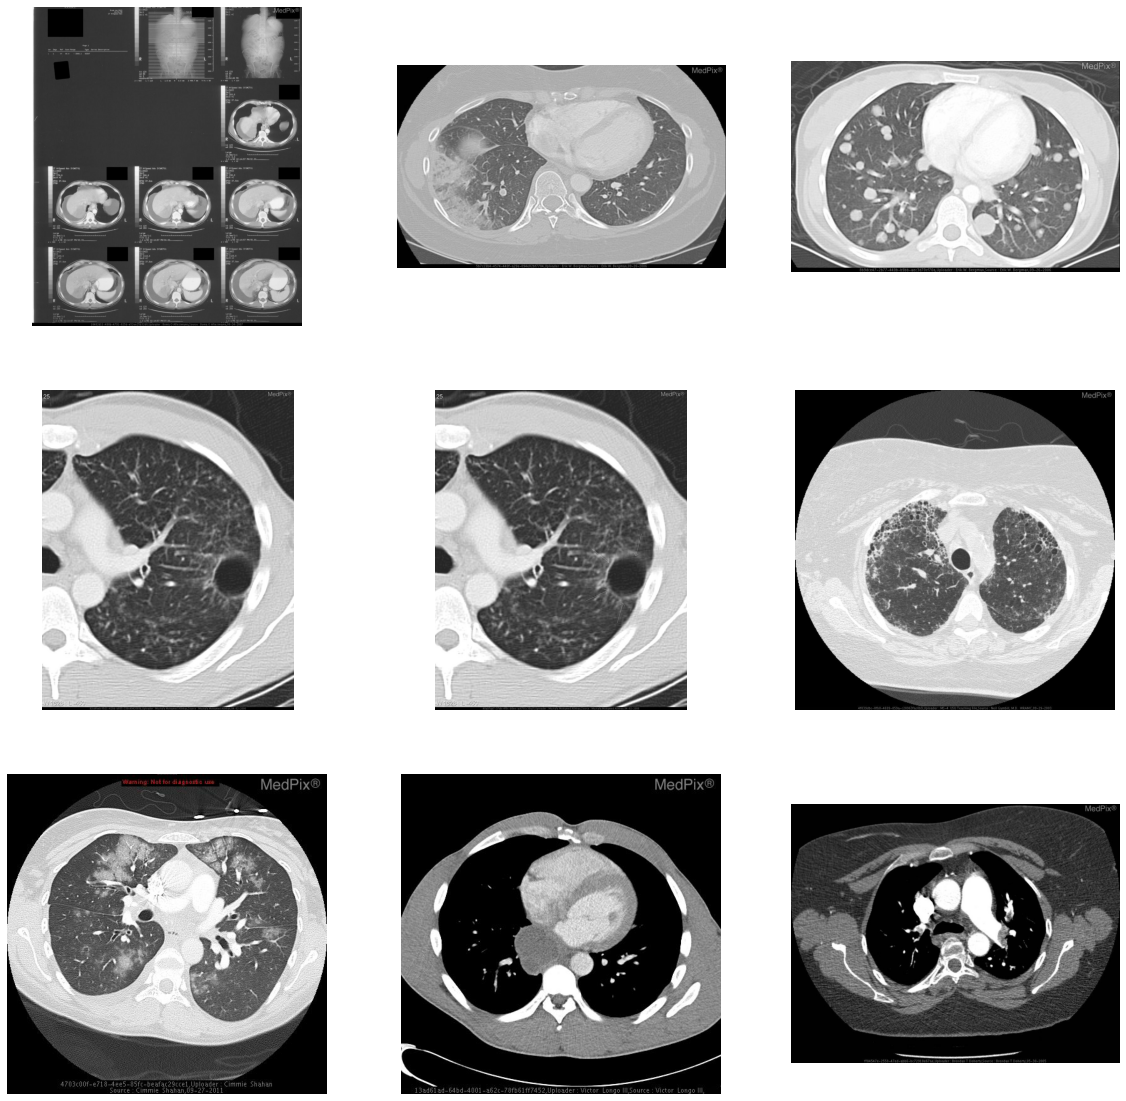

In [21]:
query = "Pulmonary embolism"
matches = find_matches(image_embeddings, [query], normalize=True)[0]

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(matches[i]))
    plt.axis("off")

In [22]:
def compute_top_k_accuracy(image_paths, k=100):
    hits = 0
    num_batches = int(np.ceil(len(image_paths) / BATCH_SIZE))
    for idx in tqdm(range(num_batches)):
        start_idx = idx * BATCH_SIZE
        end_idx = start_idx + BATCH_SIZE
        current_image_paths = image_paths[start_idx:end_idx]
        queries = [
            image_path_to_caption[image_path][0] for image_path in current_image_paths
        ]
        result = find_matches(image_embeddings, queries, k)
        hits += sum(
            [
                image_path in matches
                for (image_path, matches) in list(zip(current_image_paths, result))
            ]
        )

    return hits / len(image_paths)


print("Scoring training data...")
train_accuracy = compute_top_k_accuracy(train_image_paths)
print(f"Train accuracy: {round(train_accuracy * 100, 3)}%")

print("Scoring evaluation data...")
eval_accuracy = compute_top_k_accuracy(image_paths[TRAIN_SIZE:])
print(f"Eval accuracy: {round(eval_accuracy * 100, 3)}%")

  0%|          | 0/118 [00:00<?, ?it/s]

Scoring training data...


  0%|          | 0/26 [00:00<?, ?it/s]

Train accuracy: 0.793%
Scoring evaluation data...


100%|██████████| 26/26 [02:41<00:00,  6.23s/it]

Eval accuracy: 0.651%
